# Autoregressions

This notebook introduces autoregression modeling using the `AutoReg` model. It also covers aspects of `ar_select_order` assists in selecting models that minimize an information criteria such as the AIC. 
An autoregressive model has dynamics given by 

$$ y_t = \delta + \phi_1 y_{t-1} + \ldots + \phi_p y_{t-p} + \epsilon_t. $$

`AutoReg` also permits models with:

* Deterministic terms (`trend`)
  * `n`: No deterministic term 
  * `c`: Constant (default)
  * `ct`: Constant and time trend
  * `t`: Time trend only
* Seasonal dummies (`seasonal`)
  * `True` includes $s-1$ dummies where $s$ is the period of the time series (e.g., 12 for monthly)
* Exogenous variables (`exog`)
  * A `DataFrame` or `array` of exogenous variables to include in the model
* Omission of selected lags (`lags`)
  * If `lags` is an iterable of integers, then only these are included in the model.

The complete specification is

$$ y_t = \delta_0 + \delta_1 t + \phi_1 y_{t-1} + \ldots + \phi_p y_{t-p} + \sum_{i=1}^{s-1} \gamma_i d_i + \sum_{j=1}^{m} \kappa_j x_{t,j} + \epsilon_t. $$

where:

* $d_i$ is a seasonal dummy that is 1 if $mod(t, period) = i$. Period 0 is excluded if the model contains a constant (`c` is in `trend`).
* $t$ is a time trend ($1,2,\ldots$) that starts with 1 in the first observation.
* $x_{t,j}$ are exogenous regressors.  **Note** these are time-aligned to the left-hand-side variable when defining a model.
* $\epsilon_t$ is assumed to be a white noise process.

This first cell imports standard packages and sets plats to appear inline.

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
import pandas_datareader as pdr
import seaborn as sns
from statsmodels.tsa.ar_model import AutoReg, ar_select_order
from statsmodels.tsa.api import acf, pacf, graphics

/home/travis/miniconda/envs/statsmodels-test/lib/python3.7/site-packages/pandas_datareader/compat/__init__.py:7: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  from pandas.util.testing import assert_frame_equal


This cell sets the plotting style, registers pandas date converters for matplotlib, and sets the default figure size.

In [2]:
sns.set_style('darkgrid')
pd.plotting.register_matplotlib_converters()
# Default figure size
sns.mpl.rc('figure',figsize=(16, 6))

The first set of examples uses the month-over-month growth rate in U.S. Housing starts that has not been seasonally adjusted. The seasonality is evident by the regular pattern of peaks and troughs. We set the frequency for the time series to "MS" (month-start) to avoid warnings when using `AutoReg`.

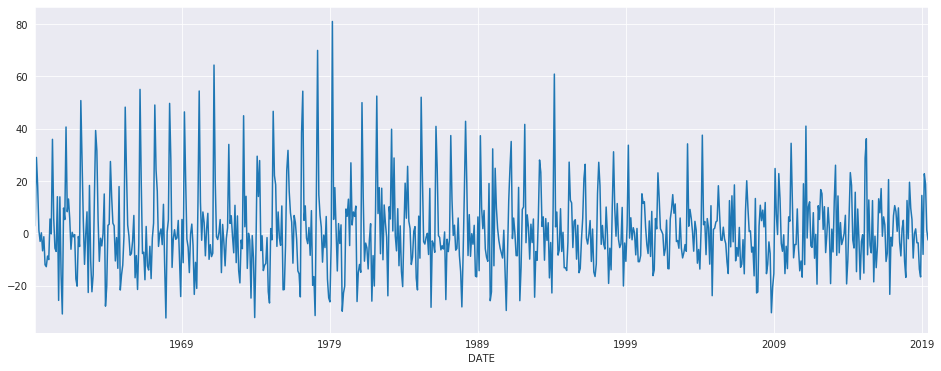

In [3]:
data = pdr.get_data_fred('HOUSTNSA', '1959-01-01', '2019-06-01')
housing = data.HOUSTNSA.pct_change().dropna()
# Scale by 100 to get percentages
housing = 100 * housing.asfreq('MS')
fig, ax = plt.subplots()
ax = housing.plot(ax=ax)

We can start with an AR(3).  While this is not a good model for this data, it demonstrates the basic use of the API.

In [4]:
mod = AutoReg(housing, 3)
res = mod.fit()
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            AutoReg Model Results                             
==============================================================================
Dep. Variable:               HOUSTNSA   No. Observations:                  725
Model:                     AutoReg(3)   Log Likelihood               -2993.442
Method:               Conditional MLE   S.D. of innovations             15.289
Date:                Fri, 21 Feb 2020   AIC                              5.468
Time:                        13:53:22   BIC                              5.500
Sample:                    05-01-1959   HQIC                             5.480
                         - 06-01-2019                                         
===============================================================================
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
intercept       1.1228      0.573      1.961      0.050       0.000       2.245
HOUSTNSA.L1     0.1910      0.036      5.235      0.000       0.120       0.263
HOUSTNSA.L2     0.0058      0.037      0.155      0.877      -0.067       0.079
HOUSTNSA.L3    -0.1939      0.036     -5.319      0.000      -0.265      -0.122
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            0.9680           -1.3298j            1.6448           -0.1499
AR.2            0.9680           +1.3298j            1.6448            0.1499
AR.3           -1.9064           -0.0000j            1.9064           -0.5000
-----------------------------------------------------------------------------
"""

`AutoReg` supports the same covariance estimators as `OLS`.  Below, we use `cov_type="HC0"`, which is White's covariance estimator. While the parameter estimates are the same, all of the quantities that depend on the standard error change.

In [5]:
res = mod.fit(cov_type="HC0")
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            AutoReg Model Results                             
==============================================================================
Dep. Variable:               HOUSTNSA   No. Observations:                  725
Model:                     AutoReg(3)   Log Likelihood               -2993.442
Method:               Conditional MLE   S.D. of innovations             15.289
Date:                Fri, 21 Feb 2020   AIC                              5.468
Time:                        13:53:22   BIC                              5.500
Sample:                    05-01-1959   HQIC                             5.480
                         - 06-01-2019                                         
===============================================================================
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
intercept       1.1228      0.601      1.869      0.062      -0.055       2.300
HOUSTNSA.L1     0.1910      0.035      5.499      0.000       0.123       0.259
HOUSTNSA.L2     0.0058      0.039      0.150      0.881      -0.070       0.081
HOUSTNSA.L3    -0.1939      0.036     -5.448      0.000      -0.264      -0.124
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            0.9680           -1.3298j            1.6448           -0.1499
AR.2            0.9680           +1.3298j            1.6448            0.1499
AR.3           -1.9064           -0.0000j            1.9064           -0.5000
-----------------------------------------------------------------------------
"""

In [6]:
sel = ar_select_order(housing, 13)
sel.ar_lags
res = sel.model.fit()
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            AutoReg Model Results                             
==============================================================================
Dep. Variable:               HOUSTNSA   No. Observations:                  725
Model:                    AutoReg(13)   Log Likelihood               -2676.157
Method:               Conditional MLE   S.D. of innovations             10.378
Date:                Fri, 21 Feb 2020   AIC                              4.722
Time:                        13:53:22   BIC                              4.818
Sample:                    03-01-1960   HQIC                             4.759
                         - 06-01-2019                                         
================================================================================
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
intercept        1.3615      0.458      2.970      0.003       0.463       2.260
HOUSTNSA.L1     -0.2900      0.036     -8.161      0.000      -0.360      -0.220
HOUSTNSA.L2     -0.0828      0.031     -2.652      0.008      -0.144      -0.022
HOUSTNSA.L3     -0.0654      0.031     -2.106      0.035      -0.126      -0.005
HOUSTNSA.L4     -0.1596      0.031     -5.166      0.000      -0.220      -0.099
HOUSTNSA.L5     -0.0434      0.031     -1.387      0.165      -0.105       0.018
HOUSTNSA.L6     -0.0884      0.031     -2.867      0.004      -0.149      -0.028
HOUSTNSA.L7     -0.0556      0.031     -1.797      0.072      -0.116       0.005
HOUSTNSA.L8     -0.1482      0.031     -4.803      0.000      -0.209      -0.088
HOUSTNSA.L9     -0.0926      0.031     -2.960      0.003      -0.154      -0.031
HOUSTNSA.L10    -0.1133      0.031     -3.665      0.000      -0.174      -0.053
HOUSTNSA.L11     0.1151      0.031      3.699      0.000       0.054       0.176
HOUSTNSA.L12     0.5352      0.031     17.133      0.000       0.474       0.596
HOUSTNSA.L13     0.3178      0.036      8.937      0.000       0.248       0.388
                                    Roots                                     
==============================================================================
                   Real          Imaginary           Modulus         Frequency
------------------------------------------------------------------------------
AR.1             1.0913           -0.0000j            1.0913           -0.0000
AR.2             0.8743           -0.5018j            1.0080           -0.0829
AR.3             0.8743           +0.5018j            1.0080            0.0829
AR.4             0.5041           -0.8765j            1.0111           -0.1669
AR.5             0.5041           +0.8765j            1.0111            0.1669
AR.6             0.0056           -1.0530j            1.0530           -0.2491
AR.7             0.0056           +1.0530j            1.0530            0.2491
AR.8            -0.5263           -0.9335j            1.0716           -0.3317
AR.9            -0.5263           +0.9335j            1.0716            0.3317
AR.10           -0.9525           -0.5880j            1.1194           -0.4120
AR.11           -0.9525           +0.5880j            1.1194            0.4120
AR.12           -1.2928           -0.2608j            1.3189           -0.4683
AR.13           -1.2928           +0.2608j            1.3189            0.4683
------------------------------------------------------------------------------
"""

`plot_predict` visualizes forecasts.  Here we produce a large number of forecasts which show the string seasonality captured by the model.

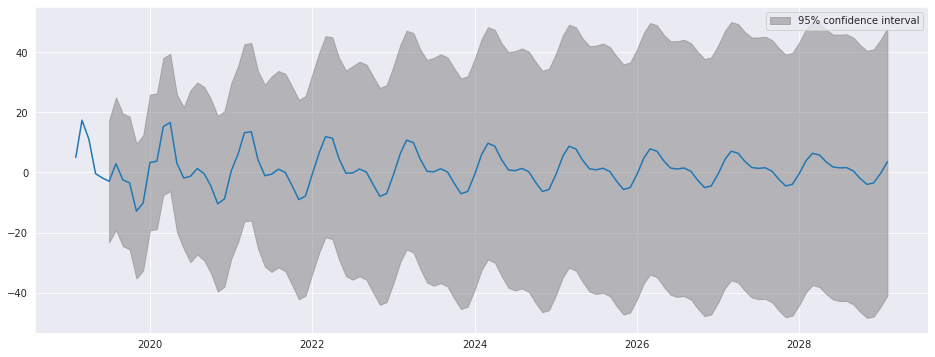

In [7]:
fig = res.plot_predict(720, 840)

`plot_diagnositcs` indicates that the model captures the key features in the data.

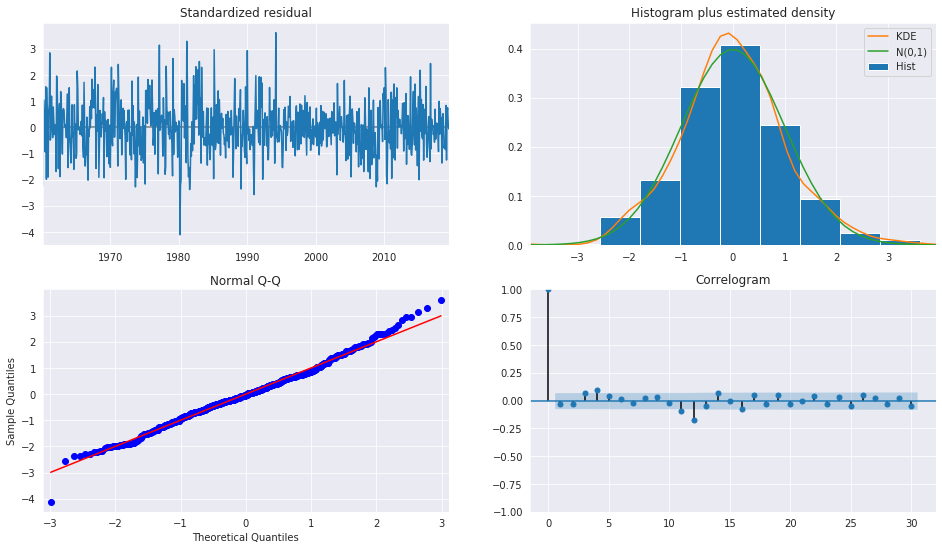

In [8]:
fig = plt.figure(figsize=(16,9))
fig = res.plot_diagnostics(fig=fig, lags=30)

## Seasonal Dummies

`AutoReg` supports seasonal dummies which are an alternative way to model seasonality.  Including the dummies shortens the dynamics to only an AR(2).

In [9]:
sel = ar_select_order(housing, 13, seasonal=True)
sel.ar_lags
res = sel.model.fit()
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            AutoReg Model Results                             
==============================================================================
Dep. Variable:               HOUSTNSA   No. Observations:                  725
Model:               Seas. AutoReg(2)   Log Likelihood               -2652.556
Method:               Conditional MLE   S.D. of innovations              9.487
Date:                Fri, 21 Feb 2020   AIC                              4.541
Time:                        13:53:24   BIC                              4.636
Sample:                    04-01-1959   HQIC                             4.578
                         - 06-01-2019                                         
===============================================================================
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
intercept       1.2726      1.373      0.927      0.354      -1.418       3.963
seasonal.1     32.6477      1.824     17.901      0.000      29.073      36.222
seasonal.2     23.0685      2.435      9.472      0.000      18.295      27.842
seasonal.3     10.7267      2.693      3.983      0.000       5.449      16.005
seasonal.4      1.6792      2.100      0.799      0.424      -2.437       5.796
seasonal.5     -4.4229      1.896     -2.333      0.020      -8.138      -0.707
seasonal.6     -4.2113      1.824     -2.309      0.021      -7.786      -0.636
seasonal.7     -6.4124      1.791     -3.581      0.000      -9.922      -2.902
seasonal.8      0.1095      1.800      0.061      0.952      -3.419       3.638
seasonal.9    -16.7511      1.814     -9.234      0.000     -20.307     -13.196
seasonal.10   -20.7023      1.862    -11.117      0.000     -24.352     -17.053
seasonal.11   -11.9554      1.778     -6.724      0.000     -15.440      -8.470
HOUSTNSA.L1    -0.2953      0.037     -7.994      0.000      -0.368      -0.223
HOUSTNSA.L2    -0.1148      0.037     -3.107      0.002      -0.187      -0.042
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1           -1.2862           -2.6564j            2.9514           -0.3218
AR.2           -1.2862           +2.6564j            2.9514            0.3218
-----------------------------------------------------------------------------
"""

The seasonal dummies are obvious in the forecasts which has a non-trivial seasonal component in all periods 10 years in to the future.

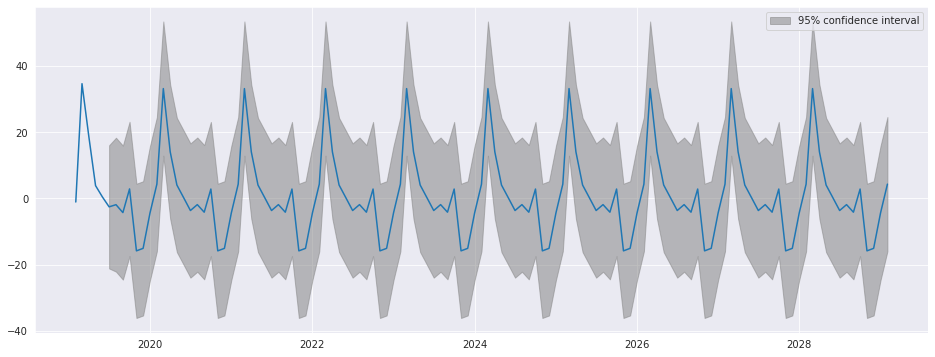

In [10]:
fig = res.plot_predict(720, 840)

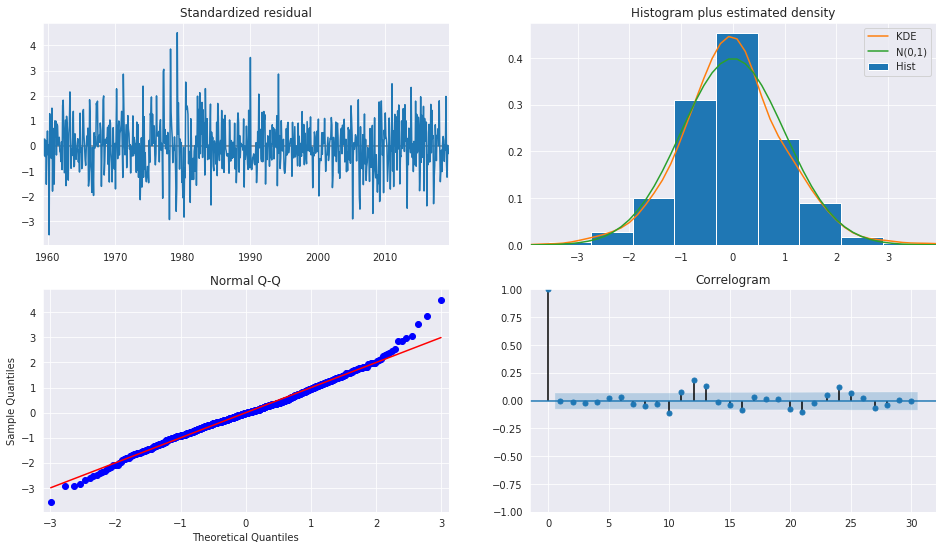

In [11]:
fig = plt.figure(figsize=(16,9))
fig = res.plot_diagnostics(lags=30, fig=fig)

## Seasonal Dynamics

While `AutoReg` does not directly support Seasonal components since it uses OLS to estimate parameters, it is possible to capture seasonal dynamics using an over-parametrized Seasonal AR that does not impose the restrictions in the Seasonal AR. 

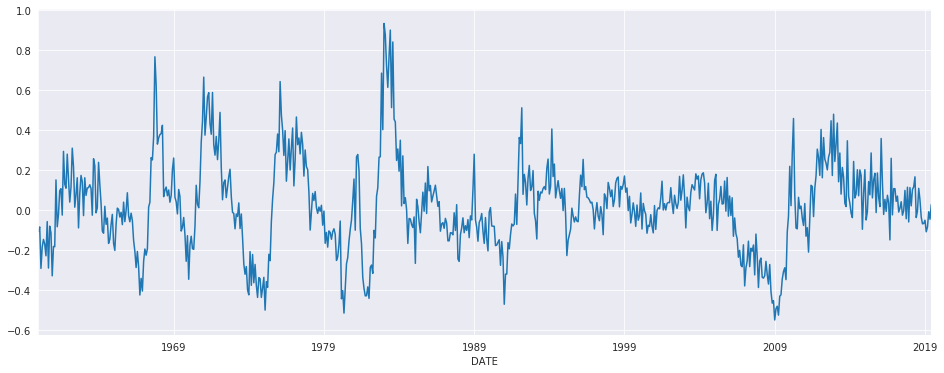

In [12]:
yoy_housing = data.HOUSTNSA.pct_change(12).resample("MS").last().dropna()
_, ax = plt.subplots()
ax = yoy_housing.plot(ax=ax)

We start by selecting a model using the simple method that only chooses the maximum lag.  All lower lags are automatically included. The maximum lag to check is set to 13 since this allows the model to next a Seasonal AR that has both a short-run AR(1) component and a Seasonal AR(1) component, so that

$$ (1-\phi_s L^{12})(1-\phi_1 L)y_t = \epsilon_t $$
which becomes
$$ y_t = \phi_1 y_{t-1} +\phi_s Y_{t-12} - \phi_1\phi_s Y_{t-13} + \epsilon_t $$

when expanded. `AutoReg` does not enforce the structure, but can estimate the nesting model 

$$ y_t = \phi_1 y_{t-1} +\phi_{12} Y_{t-12} - \phi_{13} Y_{t-13} + \epsilon_t. $$

We see that all 13 lags are selected.

In [13]:
sel = ar_select_order(yoy_housing, 13)
sel.ar_lags

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13])

It seems unlikely that all 13 lags are required.  We can set `glob=True` to search all $2^{13}$ models that include up to 13 lags.

Here we see that the first three are selected, as is the 7th, and finally the 12th and 13th are selected.  This is superficially similar to the structure described above.

After fitting the model, we take a look at the diagnostic plots that indicate that this specification appears to be adequate to capture the dynamics in the data.

In [14]:
sel = ar_select_order(yoy_housing, 13, glob=True)
sel.ar_lags
res = sel.model.fit()
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            AutoReg Model Results                             
==============================================================================
Dep. Variable:               HOUSTNSA   No. Observations:                  714
Model:             Restr. AutoReg(13)   Log Likelihood                 589.177
Method:               Conditional MLE   S.D. of innovations              0.104
Date:                Fri, 21 Feb 2020   AIC                             -4.496
Time:                        13:53:33   BIC                             -4.444
Sample:                    02-01-1961   HQIC                            -4.476
                         - 06-01-2019                                         
================================================================================
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
intercept        0.0035      0.004      0.875      0.382      -0.004       0.011
HOUSTNSA.L1      0.5640      0.035     16.167      0.000       0.496       0.632
HOUSTNSA.L2      0.2347      0.038      6.238      0.000       0.161       0.308
HOUSTNSA.L3      0.2051      0.037      5.560      0.000       0.133       0.277
HOUSTNSA.L7     -0.0903      0.030     -2.976      0.003      -0.150      -0.031
HOUSTNSA.L12    -0.3791      0.034    -11.075      0.000      -0.446      -0.312
HOUSTNSA.L13     0.3354      0.033     10.254      0.000       0.271       0.400
                                    Roots                                     
==============================================================================
                   Real          Imaginary           Modulus         Frequency
------------------------------------------------------------------------------
AR.1            -1.0309           -0.2682j            1.0652           -0.4595
AR.2            -1.0309           +0.2682j            1.0652            0.4595
AR.3            -0.7454           -0.7417j            1.0515           -0.3754
AR.4            -0.7454           +0.7417j            1.0515            0.3754
AR.5            -0.3172           -1.0221j            1.0702           -0.2979
AR.6            -0.3172           +1.0221j            1.0702            0.2979
AR.7             0.2419           -1.0573j            1.0846           -0.2142
AR.8             0.2419           +1.0573j            1.0846            0.2142
AR.9             0.7840           -0.8303j            1.1420           -0.1296
AR.10            0.7840           +0.8303j            1.1420            0.1296
AR.11            1.0730           -0.2386j            1.0992           -0.0348
AR.12            1.0730           +0.2386j            1.0992            0.0348
AR.13            1.1193           -0.0000j            1.1193           -0.0000
------------------------------------------------------------------------------
"""

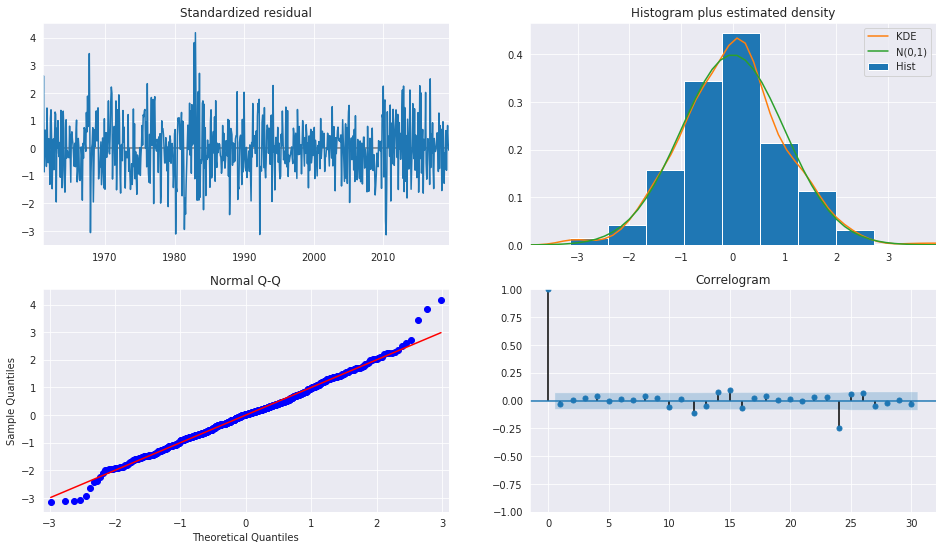

In [15]:
fig = plt.figure(figsize=(16,9))
fig = res.plot_diagnostics(fig=fig, lags=30)

We can also include seasonal dummies.  These are all insignificant since the model is using year-over-year changes.

In [16]:
sel = ar_select_order(yoy_housing, 13, glob=True, seasonal=True)
sel.ar_lags
res = sel.model.fit()
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               AutoReg Model Results                                
====================================================================================
Dep. Variable:                     HOUSTNSA   No. Observations:                  714
Model:             Restr. Seas. AutoReg(13)   Log Likelihood                 590.875
Method:                     Conditional MLE   S.D. of innovations              0.104
Date:                      Fri, 21 Feb 2020   AIC                             -4.469
Time:                              13:53:44   BIC                             -4.346
Sample:                          02-01-1961   HQIC                            -4.422
                               - 06-01-2019                                         
================================================================================
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
intercept        0.0167      0.014      1.215      0.224      -0.010       0.044
seasonal.1      -0.0179      0.019     -0.931      0.352      -0.056       0.020
seasonal.2      -0.0121      0.019     -0.630      0.528      -0.050       0.026
seasonal.3      -0.0210      0.019     -1.089      0.276      -0.059       0.017
seasonal.4      -0.0223      0.019     -1.157      0.247      -0.060       0.015
seasonal.5      -0.0224      0.019     -1.160      0.246      -0.060       0.015
seasonal.6      -0.0212      0.019     -1.096      0.273      -0.059       0.017
seasonal.7      -0.0101      0.019     -0.520      0.603      -0.048       0.028
seasonal.8      -0.0095      0.019     -0.491      0.623      -0.047       0.028
seasonal.9      -0.0049      0.019     -0.252      0.801      -0.043       0.033
seasonal.10     -0.0084      0.019     -0.435      0.664      -0.046       0.030
seasonal.11     -0.0077      0.019     -0.400      0.689      -0.046       0.030
HOUSTNSA.L1      0.5630      0.035     16.160      0.000       0.495       0.631
HOUSTNSA.L2      0.2347      0.038      6.248      0.000       0.161       0.308
HOUSTNSA.L3      0.2075      0.037      5.634      0.000       0.135       0.280
HOUSTNSA.L7     -0.0916      0.030     -3.013      0.003      -0.151      -0.032
HOUSTNSA.L12    -0.3810      0.034    -11.149      0.000      -0.448      -0.314
HOUSTNSA.L13     0.3373      0.033     10.327      0.000       0.273       0.401
                                    Roots                                     
==============================================================================
                   Real          Imaginary           Modulus         Frequency
------------------------------------------------------------------------------
AR.1            -1.0305           -0.2681j            1.0648           -0.4595
AR.2            -1.0305           +0.2681j            1.0648            0.4595
AR.3            -0.7447           -0.7414j            1.0509           -0.3754
AR.4            -0.7447           +0.7414j            1.0509            0.3754
AR.5            -0.3172           -1.0215j            1.0696           -0.2979
AR.6            -0.3172           +1.0215j            1.0696            0.2979
AR.7             0.2416           -1.0568j            1.0841           -0.2142
AR.8             0.2416           +1.0568j            1.0841            0.2142
AR.9             0.7837           -0.8304j            1.1418           -0.1296
AR.10            0.7837           +0.8304j            1.1418            0.1296
AR.11            1.0724           -0.2383j            1.0986           -0.0348
AR.12            1.0724           +0.2383j            1.0986            0.0348
AR.13            1.1192           -0.0000j            1.1192           -0.0000
------------------------------------------------------------------------------
"""

## Industrial Production

We will use the industrial production index data to examine forecasting.

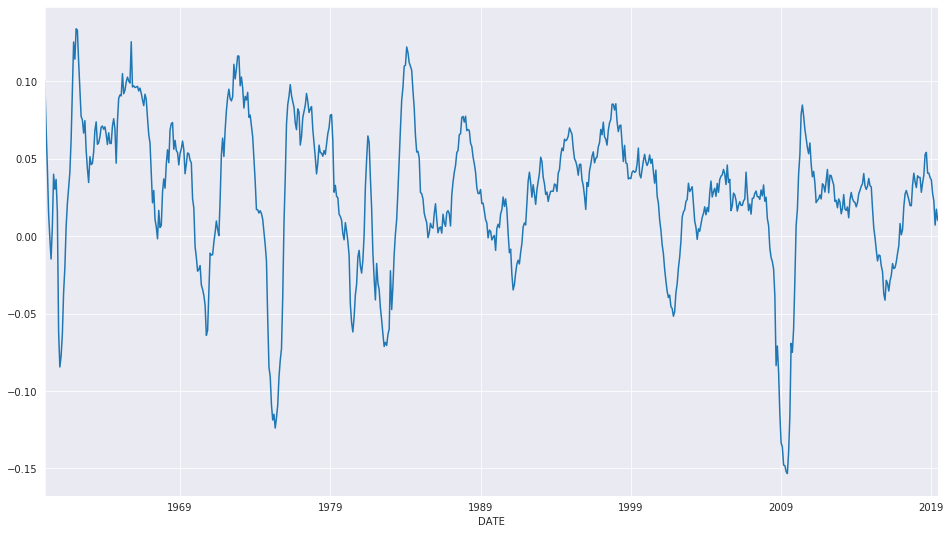

In [17]:
data = pdr.get_data_fred('INDPRO', '1959-01-01', '2019-06-01')
ind_prod = data.INDPRO.pct_change(12).dropna().asfreq('MS')
_, ax = plt.subplots(figsize=(16,9))
ind_prod.plot(ax=ax)

We will start by selecting a model using up to 12 lags.  An AR(13) minimizes the BIC criteria even though many coefficients are insignificant.

In [18]:
sel = ar_select_order(ind_prod, 13, 'bic')
res = sel.model.fit()
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            AutoReg Model Results                             
==============================================================================
Dep. Variable:                 INDPRO   No. Observations:                  714
Model:                    AutoReg(13)   Log Likelihood                2318.848
Method:               Conditional MLE   S.D. of innovations              0.009
Date:                Fri, 21 Feb 2020   AIC                             -9.411
Time:                        13:53:45   BIC                             -9.313
Sample:                    02-01-1961   HQIC                            -9.373
                         - 06-01-2019                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0012      0.000      2.896      0.004       0.000       0.002
INDPRO.L1      1.1504      0.035     32.940      0.000       1.082       1.219
INDPRO.L2     -0.0747      0.053     -1.407      0.159      -0.179       0.029
INDPRO.L3      0.0043      0.053      0.081      0.935      -0.099       0.107
INDPRO.L4      0.0027      0.053      0.052      0.959      -0.100       0.106
INDPRO.L5     -0.1383      0.052     -2.642      0.008      -0.241      -0.036
INDPRO.L6      0.0085      0.052      0.163      0.871      -0.094       0.111
INDPRO.L7      0.0375      0.052      0.720      0.471      -0.065       0.139
INDPRO.L8     -0.0235      0.052     -0.453      0.651      -0.125       0.078
INDPRO.L9      0.0945      0.052      1.824      0.068      -0.007       0.196
INDPRO.L10    -0.0844      0.052     -1.627      0.104      -0.186       0.017
INDPRO.L11     0.0024      0.052      0.047      0.962      -0.099       0.104
INDPRO.L12    -0.3809      0.052     -7.367      0.000      -0.482      -0.280
INDPRO.L13     0.3589      0.033     10.916      0.000       0.294       0.423
                                    Roots                                     
==============================================================================
                   Real          Imaginary           Modulus         Frequency
------------------------------------------------------------------------------
AR.1            -1.0411           -0.2889j            1.0804           -0.4569
AR.2            -1.0411           +0.2889j            1.0804            0.4569
AR.3            -0.7774           -0.8064j            1.1201           -0.3721
AR.4            -0.7774           +0.8064j            1.1201            0.3721
AR.5            -0.2760           -1.0530j            1.0886           -0.2908
AR.6            -0.2760           +1.0530j            1.0886            0.2908
AR.7             0.2719           -1.0515j            1.0861           -0.2097
AR.8             0.2719           +1.0515j            1.0861            0.2097
AR.9             0.8019           -0.7297j            1.0842           -0.1175
AR.10            0.8019           +0.7297j            1.0842            0.1175
AR.11            1.0224           -0.2214j            1.0461           -0.0339
AR.12            1.0224           +0.2214j            1.0461            0.0339
AR.13            1.0578           -0.0000j            1.0578           -0.0000
------------------------------------------------------------------------------
"""

We can also use a global search which allows longer lags to enter if needed without requiring the shorter lags. Here we see many lags dropped. The model indicates there may be some seasonality in the data. 

In [19]:
sel = ar_select_order(ind_prod, 13, 'bic', glob=True)
sel.ar_lags
res_glob = sel.model.fit()
res_glob.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            AutoReg Model Results                             
==============================================================================
Dep. Variable:                 INDPRO   No. Observations:                  714
Model:             Restr. AutoReg(13)   Log Likelihood                2313.420
Method:               Conditional MLE   S.D. of innovations              0.009
Date:                Fri, 21 Feb 2020   AIC                             -9.421
Time:                        13:53:53   BIC                             -9.382
Sample:                    02-01-1961   HQIC                            -9.406
                         - 06-01-2019                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0013      0.000      2.986      0.003       0.000       0.002
INDPRO.L1      1.0882      0.013     80.869      0.000       1.062       1.115
INDPRO.L5     -0.1057      0.016     -6.649      0.000      -0.137      -0.075
INDPRO.L12    -0.3852      0.034    -11.404      0.000      -0.451      -0.319
INDPRO.L13     0.3587      0.032     11.315      0.000       0.297       0.421
                                    Roots                                     
==============================================================================
                   Real          Imaginary           Modulus         Frequency
------------------------------------------------------------------------------
AR.1            -1.0518           -0.2762j            1.0875           -0.4591
AR.2            -1.0518           +0.2762j            1.0875            0.4591
AR.3            -0.7718           -0.7796j            1.0970           -0.3742
AR.4            -0.7718           +0.7796j            1.0970            0.3742
AR.5            -0.2714           -1.0479j            1.0825           -0.2903
AR.6            -0.2714           +1.0479j            1.0825            0.2903
AR.7             0.2820           -1.0573j            1.0943           -0.2085
AR.8             0.2820           +1.0573j            1.0943            0.2085
AR.9             0.8021           -0.7558j            1.1021           -0.1203
AR.10            0.8021           +0.7558j            1.1021            0.1203
AR.11            1.0189           -0.2198j            1.0423           -0.0338
AR.12            1.0189           +0.2198j            1.0423            0.0338
AR.13            1.0578           -0.0000j            1.0578           -0.0000
------------------------------------------------------------------------------
"""

`plot_predict` can be used to produce forecast plots along with confidence intervals. Here we produce forecasts starting at the last observation and continuing for 18 months.

In [20]:
ind_prod.shape

(714,)

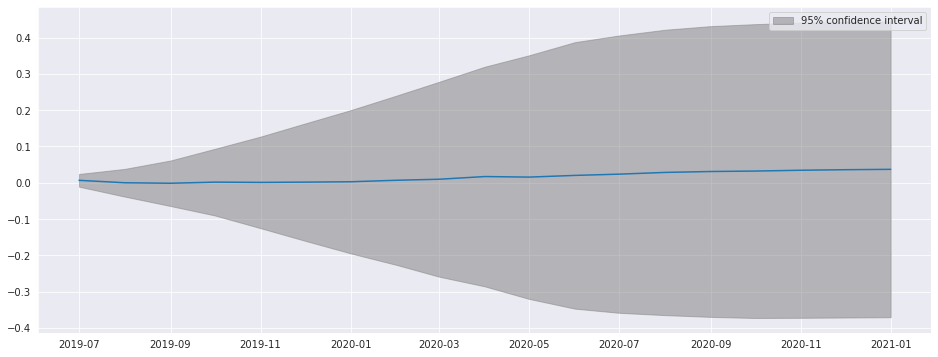

In [21]:
fig = res_glob.plot_predict(start=714, end=732)

The forecasts from the full model and the restricted model are very similar. I also include an AR(5) which has very different dynamics

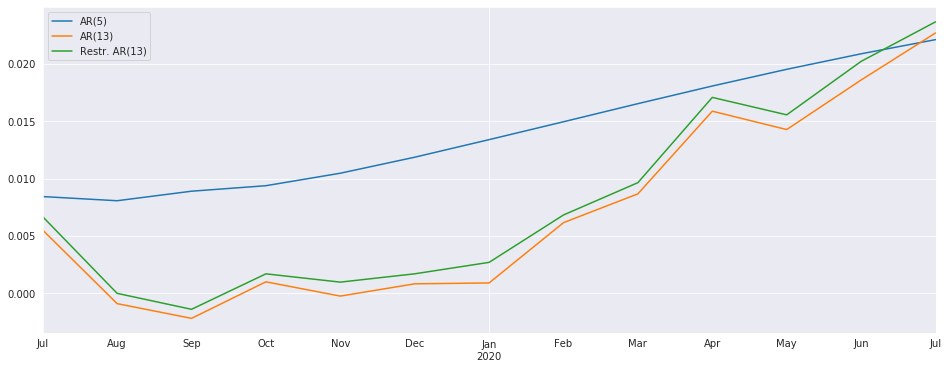

In [22]:
res_ar5 = AutoReg(ind_prod, 5).fit()
predictions = pd.DataFrame({"AR(5)": res_ar5.predict(start=714, end=726),
                            "AR(13)": res.predict(start=714, end=726),
                            "Restr. AR(13)": res_glob.predict(start=714, end=726)})
_, ax = plt.subplots()
ax = predictions.plot(ax=ax)

The diagnostics indicate the model captures most of the the dynamics in the data. The ACF shows a patters at the seasonal frequency and so a more complete seasonal model (`SARIMAX`) may be needed.

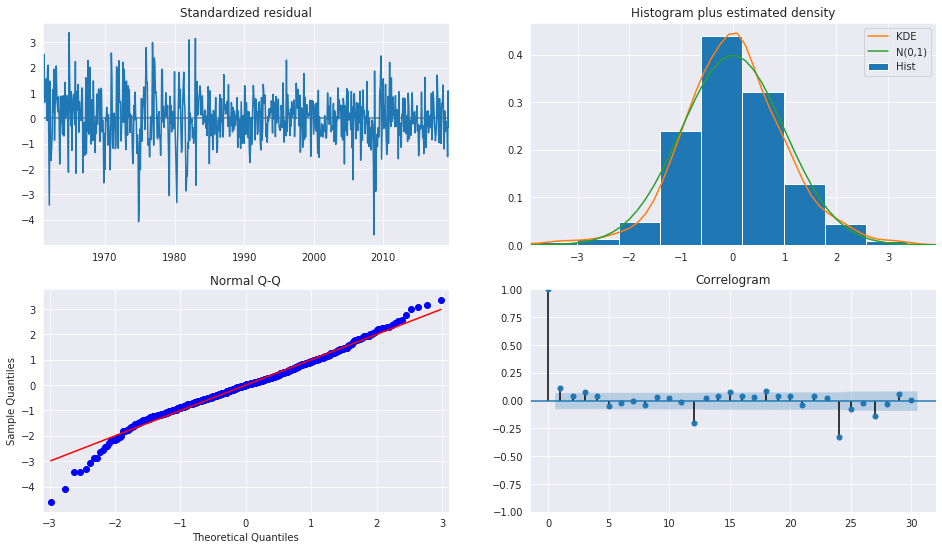

In [23]:
fig = plt.figure(figsize=(16,9))
fig = res_glob.plot_diagnostics(fig=fig, lags=30)

# Forecasting

Forecasts are produced using the `predict` method from a results instance. The default produces static forecasts which are one-step forecasts. Producing multi-step forecasts requires using `dynamic=True`.  

In this next cell, we produce 12-step-heard forecasts for the final 24 periods in the sample.  This requires a loop.

**Note**: These are technically in-sample since the data we are forecasting was used to estimate parameters. Producing OOS forecasts requires two models.  The first must exclude the OOS period.  The second uses the `predict` method from the full-sample model with the parameters from the shorter sample model that excluded the OOS period.

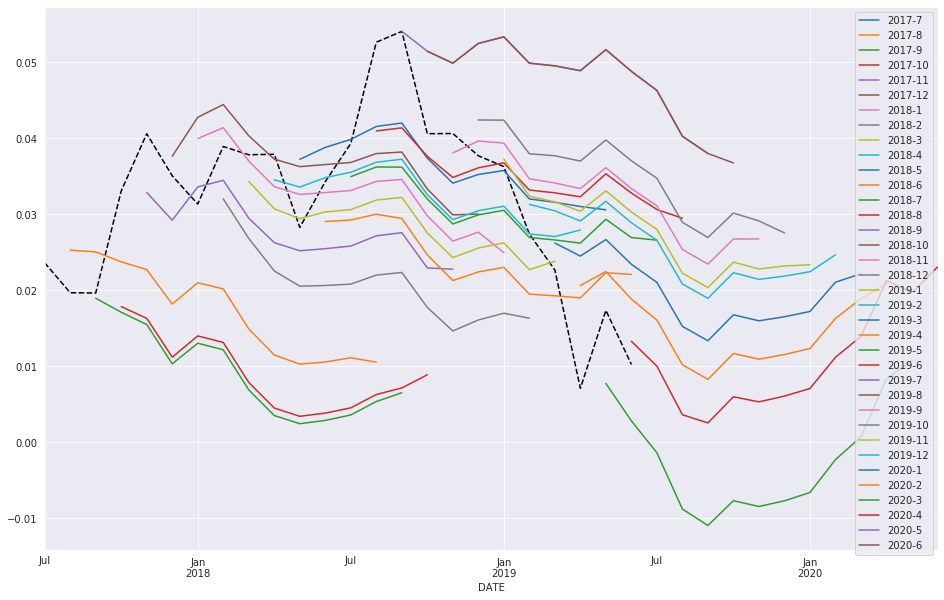

In [24]:
import numpy as np
start = ind_prod.index[-24]
forecast_index = pd.date_range(start, freq=ind_prod.index.freq, periods=36)
cols = ['-'.join(str(val) for val in (idx.year, idx.month)) for idx in forecast_index]
forecasts = pd.DataFrame(index=forecast_index,columns=cols)
for i in range(1, 24):
    fcast = res_glob.predict(start=forecast_index[i], end=forecast_index[i+12], dynamic=True)
    forecasts.loc[fcast.index, cols[i]] = fcast
_, ax = plt.subplots(figsize=(16, 10))
ind_prod.iloc[-24:].plot(ax=ax, color="black", linestyle="--")
ax = forecasts.plot(ax=ax)

## Comparing to SARIMAX

`SARIMAX` is an implementation of a Seasonal Autoregressive Integrated Moving Average with eXogenous regressors model.  It supports:

* Specification of seasonal and nonseasonal AR and MA components
* Inclusion of Exogenous variables
* Full maximum-likelihood estimation using the Kalman Filter

This model is more feature rich than `AutoReg`. Unlike `SARIMAX`, `AutoReg` estimates parameters using OLS.  This is faster and the problem is globally convex, and so there are no issues with local minima. The closed-form estimator and its performance are the key advantages of `AutoReg` over `SARIMAX` when comparing AR(P) models.  `AutoReg` also support seasonal dummies, which can be used with `SARIMAX` if the user includes them as exogenous regressors. 

In [25]:
from statsmodels.tsa.api import SARIMAX

sarimax_mod = SARIMAX(ind_prod, order=((1,5,12,13),0, 0), trend='c')
sarimax_res = sarimax_mod.fit()
sarimax_res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                     
=========================================================================================
Dep. Variable:                            INDPRO   No. Observations:                  714
Model:             SARIMAX([1, 5, 12, 13], 0, 0)   Log Likelihood                2302.146
Date:                           Fri, 21 Feb 2020   AIC                          -4592.293
Time:                                   13:54:00   BIC                          -4564.867
Sample:                               01-01-1960   HQIC                         -4581.701
                                    - 06-01-2019                                         
Covariance Type:                             opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0011      0.000      2.627      0.009       0.000       0.002
ar.L1          1.0798      0.010    106.388      0.000       1.060       1.100
ar.L5         -0.0849      0.011     -7.467      0.000      -0.107      -0.063
ar.L12        -0.4392      0.026    -16.935      0.000      -0.490      -0.388
ar.L13         0.4032      0.025     15.831      0.000       0.353       0.453
sigma2      9.179e-05   3.13e-06     29.366      0.000    8.57e-05    9.79e-05
===================================================================================
Ljung-Box (Q):                      177.22   Jarque-Bera (JB):               928.85
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               0.38   Skew:                            -0.63
Prob(H) (two-sided):                  0.00   Kurtosis:                         8.44
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [26]:
sarimax_params = sarimax_res.params.iloc[:-1].copy()
sarimax_params.index = res_glob.params.index
params = pd.concat([res_glob.params, sarimax_params], axis=1, sort=False)
params.columns = ["AutoReg", "SARIMAX"]
params

AutoReg   SARIMAX
intercept   0.001292  0.001140
INDPRO.L1   1.088215  1.079829
INDPRO.L5  -0.105668 -0.084904
INDPRO.L12 -0.385171 -0.439175
INDPRO.L13  0.358738  0.403241